In [1]:
# ================================
# DAY 7 — STARTER CELL
# ================================

# Imports
import numpy as np
import pandas as pd
from pathlib import Path
import gzip
from Bio import SeqIO

# Paths
ROOT = Path("..").resolve()
DATA = ROOT / "data"

# --------------------------------
# Load df22 that you saved in Day 6
# --------------------------------
df22 = pd.read_csv(DATA / "df22_sequences.csv")

print("Loaded df22:", df22.shape)
print(df22.head())

# --------------------------------
# Define column names
# --------------------------------
# Adjust REF_COL and ALT_COL below if your df22 uses different names
print("Columns:", df22.columns.tolist())

CHR_COL   = "Chromosome"
POS_COL   = "Start"
REF_COL   = "ReferenceAlleleVCF"      # change if needed
ALT_COL   = "AlternateAlleleVCF"      # change if needed
LABEL_COL = "label"
SEQ101_COL = "seq101"

# --------------------------------
# Load chr22 reference genome
# --------------------------------
chr22_gz = DATA / "chr22.fa.gz"

ref_dict = {}
with gzip.open(chr22_gz, "rt") as handle:
    for rec in SeqIO.parse(handle, "fasta"):
        key = rec.id.replace("chr", "")
        ref_dict[key] = rec.seq    # store Seq object directly

print("Reference genomes loaded:", list(ref_dict.keys()))

# --------------------------------
# Sequence window extractor
# --------------------------------
def fetch_seq_window(chrom, pos, flank=100):
    chrom = str(chrom).replace("chr","")
    if chrom not in ref_dict:
        return None
    seq = ref_dict[chrom]
    pos = int(pos)
    start = max(pos - flank, 0)
    end   = pos + flank + 1
    if end > len(seq):
        return None
    return str(seq[start:end]).upper()

# --------------------------------
# One-hot Encoding Setup
# --------------------------------
BASE_TO_INT = np.full(256, -1, dtype=np.int8)
for base, idx in zip("ACGTacgt", [0,1,2,3,0,1,2,3]):
    BASE_TO_INT[ord(base)] = idx

EYE4 = np.eye(4, dtype=np.float32)

def one_hot_vec(seq: str) -> np.ndarray:
    b = np.frombuffer(seq.encode(), dtype=np.uint8)
    idx = BASE_TO_INT[b]
    oh = np.zeros((len(idx), 4), dtype=np.float32)
    mask = idx >= 0
    oh[mask] = EYE4[idx[mask]]
    return oh

print("Starter cell loaded successfully.")


Loaded df22: (437, 7)
   Chromosome     Start ReferenceAlleleVCF AlternateAlleleVCF  \
0          22  41320486                  G                  T   
1          22  40924482                  G                  T   
2          22  31011610                  G                  C   
3          22  30615623                  G                  C   
4          22  31009031                  T                  G   

  ClinicalSignificance  label  \
0           Pathogenic      1   
1           Pathogenic      1   
2               Benign      0   
3               Benign      0   
4           Pathogenic      1   

                                              seq101  
0  CCCTTGAGGGTACCACACAATCTAGGAGTCCAGGGGGCCATGGGGG...  
1  GCCCCGTTCCCTCCCTCTGCAGCCTGGGATGGTAATCACAATTGAG...  
2  TCTCAAAAGAAGACATTTATACAGCCAAAAAACACATGAAAAAATG...  
3  TCTCTCTCTTCCTCACTCTATCACCAGTTCCTCATGACTTCCCCCA...  
4  TGGGTTCAGGTGATTCTCCTGTCTCGGCCCCCCGAGTAGCTGGGAC...  
Columns: ['Chromosome', 'Start', 'ReferenceAlleleVCF', 'Al

In [3]:
WINDOW = 100  # 100 bp on each side

df22["seq201"] = df22.apply(
    lambda row: fetch_seq_window(row[CHR_COL], row[POS_COL], flank=WINDOW),
    axis=1
)

df22 = df22.dropna(subset=["seq201"]).reset_index(drop=True)

print("New df22 shape:", df22.shape)
print(df22["seq201"].iloc[0], len(df22["seq201"].iloc[0]))


New df22 shape: (437, 8)
GTAGCTCAAGCCTGTGTGGGAAAGGGCAGGTGCCCTCTATGCCCCCTTGTCCCTTGAGGGTACCACACAATCTAGGAGTCCAGGGGGCCATGGGGGTGGAGGACACTGGCCTGAGGGTGGTCATCGCCCTCAGGGACACGCCTCCCGACATGGGGAAGGGAATGAGAGTGGGAGTGAGAGCACCCAATCACAGGACCCACG 201


In [7]:
#take sequences and labels
seqs = df22["seq201"].tolist()
y = df22[LABEL_COL].to_numpy().astype(np.int64)

#one-hot encode each sequence
X = np.stack ([one_hot_vec(s) for s in seqs], axis = 0)

X.shape, y.shape, np.bincount(y)

((437, 201, 4), (437,), array([131, 306]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size = 0.4, random_state = 42, stratify = y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size = 0.5, random_state = 42, stratify = y_tmp
)

X_train.shape, X_val.shape, X_test.shape, np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

((262, 201, 4),
 (87, 201, 4),
 (88, 201, 4),
 array([ 79, 183]),
 array([26, 61]),
 array([26, 62]))

In [12]:
import torch
import torch.nn as nn

class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 7)
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 7)
        self.conv3 = nn.Conv1d(64, 64, kernel_size = 7)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        #compute output length after 3 conv+pool blocks
        L = 201
        for _ in range(3):
            L = L-7 + 1 #conv reduces Length by k-1
            L = L //2 #maxpool halves

        self.fc = nn.Linear(L * 64, 2)
    
    def forward(self, x):
        #x: (B, 201, 4) -> (B, 4, 201)
        x = x.permute(0, 2, 1)

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.dropout(self.conv3(x)))
        x = self.relu(x)

        x = x.flatten(1)
        return self.fc(x)

model = BetterCNN()
model
        

BetterCNN(
  (conv1): Conv1d(4, 32, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1216, out_features=2, bias=True)
)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train, dtype = torch.float32)
y_train_t = torch.tensor(y_train, dtype = torch.long)
X_val_t = torch.tensor(X_val, dtype = torch.float32)
y_val_t = torch.tensor(y_val, dtype = torch.long)
X_test_t = torch.tensor(X_test, dtype = torch.float32)
y_test_t = torch.tensor(y_test, dtype = torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size = 32, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size = 32, shuffle = False)

In [21]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

loss_history = []
val_auc_history = []

EPOCHS = 20

for ep in range(EPOCHS):
    # TRAIN
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)

    #VALIDATION
     # ---- Validate ----
    model.eval()
    with torch.no_grad():
        logits = model(X_val_t)
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        val_auc = roc_auc_score(y_val_t.cpu().numpy(), probs)
        val_auc_history.append(val_auc)

    print(f"Epoch {ep+1:02d} — loss={avg_loss:.4f} — val_AUC={val_auc:.3f}")

    

Epoch 01 — loss=0.6397 — val_AUC=0.453
Epoch 02 — loss=0.6064 — val_AUC=0.504
Epoch 03 — loss=0.6119 — val_AUC=0.526
Epoch 04 — loss=0.6321 — val_AUC=0.534
Epoch 05 — loss=0.6189 — val_AUC=0.521
Epoch 06 — loss=0.6178 — val_AUC=0.515
Epoch 07 — loss=0.5798 — val_AUC=0.489
Epoch 08 — loss=0.5646 — val_AUC=0.479
Epoch 09 — loss=0.5659 — val_AUC=0.475
Epoch 10 — loss=0.5272 — val_AUC=0.482
Epoch 11 — loss=0.5112 — val_AUC=0.478
Epoch 12 — loss=0.4716 — val_AUC=0.478
Epoch 13 — loss=0.4245 — val_AUC=0.498
Epoch 14 — loss=0.3592 — val_AUC=0.498
Epoch 15 — loss=0.2897 — val_AUC=0.509
Epoch 16 — loss=0.2638 — val_AUC=0.506
Epoch 17 — loss=0.2289 — val_AUC=0.497
Epoch 18 — loss=0.1628 — val_AUC=0.501
Epoch 19 — loss=0.1335 — val_AUC=0.499
Epoch 20 — loss=0.1326 — val_AUC=0.495


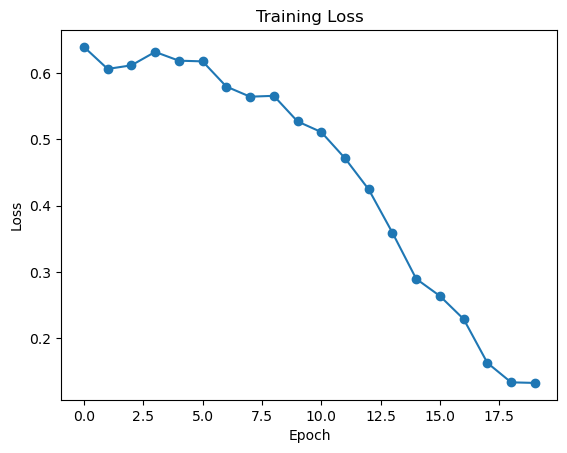

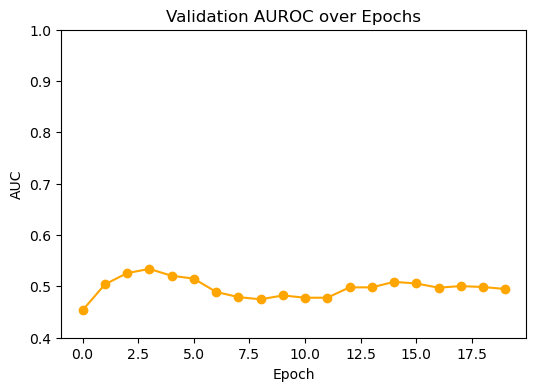

Saved validation AUC figure to: ..\figures\day7_val_auc.png


In [22]:
import matplotlib.pyplot as plt 
from pathlib import Path

# Create figures folder if it doesn't exist
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

# Training Loss Curve
plt.figure()
plt.plot(loss_history, marker = "o")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
loss_fig_path = FIG_DIR / "day7_training_loss.png"
plt.savefig(loss_fig_path, dpi=300, bbox_inches="tight")
plt.show()

#Validation AUC curve
plt.figure(figsize=(6,4))
plt.plot(val_auc_history, marker="o", color="orange")
plt.title("Validation AUROC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.ylim(0.4, 1.0)
plt.grid(False)
auc_fig_path = FIG_DIR / "day7_val_auc.png"
plt.savefig(auc_fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved validation AUC figure to:", auc_fig_path)

In [23]:
with torch.no_grad():
    logits_test = model(X_test_t)
    probs_test = F.softmax(logits_test, dim = 1)[:, 1].cpu().numpy()

test_auc = roc_auc_score(y_test_t.cpu().numpy(), probs_test)
test_auc

0.5235732009925558